# Разработка A/B-тестирования и анализ результатов

Вы работаете продуктовым аналитиком в компании, которая разрабатывает развлекательное приложение с функцией «бесконечной» ленты, как, например, в приложениях с короткими видео. В вашем приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Вас, как аналитика, просят помочь рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

## Описание данных

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-15 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).

#### План работы

**Цель проекта:** Оценить эффективность двух версий интерфейса мобильного приложения для повышения вовлеченности пользователей и улучшения ключевых метрик.

Основные вопросы исследования:
- Какая из версий интерфейса (A или B) демонстрирует лучшие показатели?
- Какие рекомендации можно сформулировать для дальнейшего развития продукта?

Методология исследования
Сбор данных:
- Формирование выборки пользователей
- Случайное распределение пользователей по тестовым группам A и B
- Сбор данных о взаимодействии пользователей с приложением в период октября 2025 года

Основные метрики для анализа:
- Количество просмотренных страниц (page_counter)
- Коэффициент регистрации (registration_flag)
- Количество и качество сессий (good_session)

Анализ данных
Предварительная обработка:
- Проверка целостности и качества данных
- Фильтрация нерепрезентативных данных
- Сегментация пользователей по устройствам (Android, iPhone, PC, Mac) и регионам (CIS, EU, MENA)

Анализ по устройствам:
- Сравнение показателей групп A и B для разных типов устройств

Анализ по регионам:
- Сравнение эффективности версий в разных географических зонах

Статистическая оценка результатов
Проверка статистических гипотез:
- Формулировка нулевой и альтернативной гипотез
- Расчет статистической значимости различий между группами
- Оценка достоверности результатов

Выводы и рекомендации
Интерпретация результатов:
- Определение наиболее эффективной версии интерфейса

Практические рекомендации:
- Стратегия полномасштабного внедрения успешной версии

#### Обновляем модули и библиотеки

In [1]:
#pip install --upgrade pandas numpy scipy matplotlib seaborn statsmodels

In [2]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest

#### Работа с историческими данными (EDA)

#### Загрузка исторических данных


In [3]:
#Сохраняем в датафрейм наши данные
try:
    sessions_history = pd.read_csv('/home/ray/Загрузки/Ya.Practikum/Sprint_10 A-B/sessions_project_history.csv') 
except:
    sessions_history = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_history.csv')

In [4]:
# Выводим базовую информацию о датафрейме
print(sessions_history.info())
sessions_history.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435924 entries, 0 to 435923
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   user_id            435924 non-null  object
 1   session_id         435924 non-null  object
 2   session_date       435924 non-null  object
 3   session_start_ts   435924 non-null  object
 4   install_date       435924 non-null  object
 5   session_number     435924 non-null  int64 
 6   registration_flag  435924 non-null  int64 
 7   page_counter       435924 non-null  int64 
 8   region             435924 non-null  object
 9   device             435924 non-null  object
dtypes: int64(3), object(7)
memory usage: 33.3+ MB
None


,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


#### Знакомство с данными
- Для каждого уникального пользователя `user_id` рассчитываем количество уникальных сессий `session_id`.
- Выведим на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий.
- Изучаем таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных

In [5]:
# Находим все сессии самого активного пользователя
sh_grp = sessions_history['user_id'].value_counts().sort_values(ascending=False).idxmax()
sessions_history[sessions_history['user_id'] == sh_grp]

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


#### Анализ числа регистраций
Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя исторические данные, визуализируем, как менялось число регистраций в приложении за время его существования.


In [6]:
# Агрегируем количество уникальных и зарегистрированных пользователей по дням
sh_agg = sessions_history.groupby('session_date').agg(
    unique_users=('user_id', 'nunique'),
    total_registrations=('registration_flag', 'sum'))

In [7]:
# Выделяем уникальные дни для оси Х
sh_agg_x = sh_agg.index.unique()

In [8]:
# Выделяем агрегированные столбцы для осей Y
sh_agg_y1 = sh_agg['unique_users']
sh_agg_y2 = sh_agg['total_registrations']

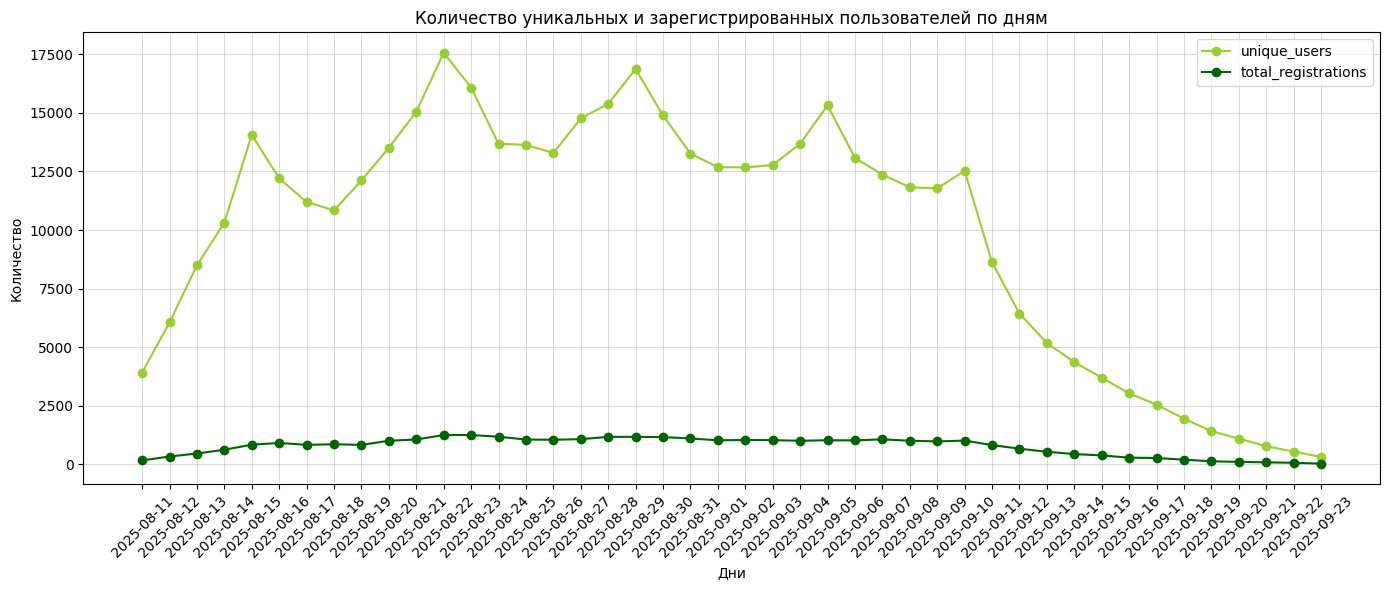

In [9]:
# Визуализируем
plt.figure(figsize=(14, 6))

plt.plot(sh_agg_x, sh_agg_y1, label='unique_users', color='yellowgreen', marker='o')
plt.plot(sh_agg_x, sh_agg_y2, label='total_registrations', color='darkgreen', marker='o')

plt.title('Количество уникальных и зарегистрированных пользователей по дням')
plt.xlabel('Дни')
plt.ylabel('Количество')
plt.legend()
plt.grid(linewidth=0.5, alpha=0.7)
plt.xticks(rotation=45) 
plt.tight_layout()  

**Наблюдения**

Общие тенденции
- Значительный разрыв между количеством уникальных пользователей и количеством регистраций — число ежедневных посетителей в 5-10 раз превышает число регистраций
- Низкая конверсия в регистрацию — большинство уникальных пользователей не регистрируются

Динамика посещаемости
- Начальный рост: с начала августа 2025 года наблюдается стремительный рост уникальных пользователей с ~4000 до ~17500
- Период стабильности: середина августа - начало сентября показывает стабильно высокие показатели (12000-15000 уникальных пользователей)
- Резкий спад: с начала сентября происходит стремительное снижение посещаемости до практически нулевых значений к концу периода

In [10]:
# Создаем серию с соотношением зарегистрированных к уникальным пользователям по дням в %
sh_agg_rel = sh_agg['total_registrations'] / sh_agg['unique_users'] * 100

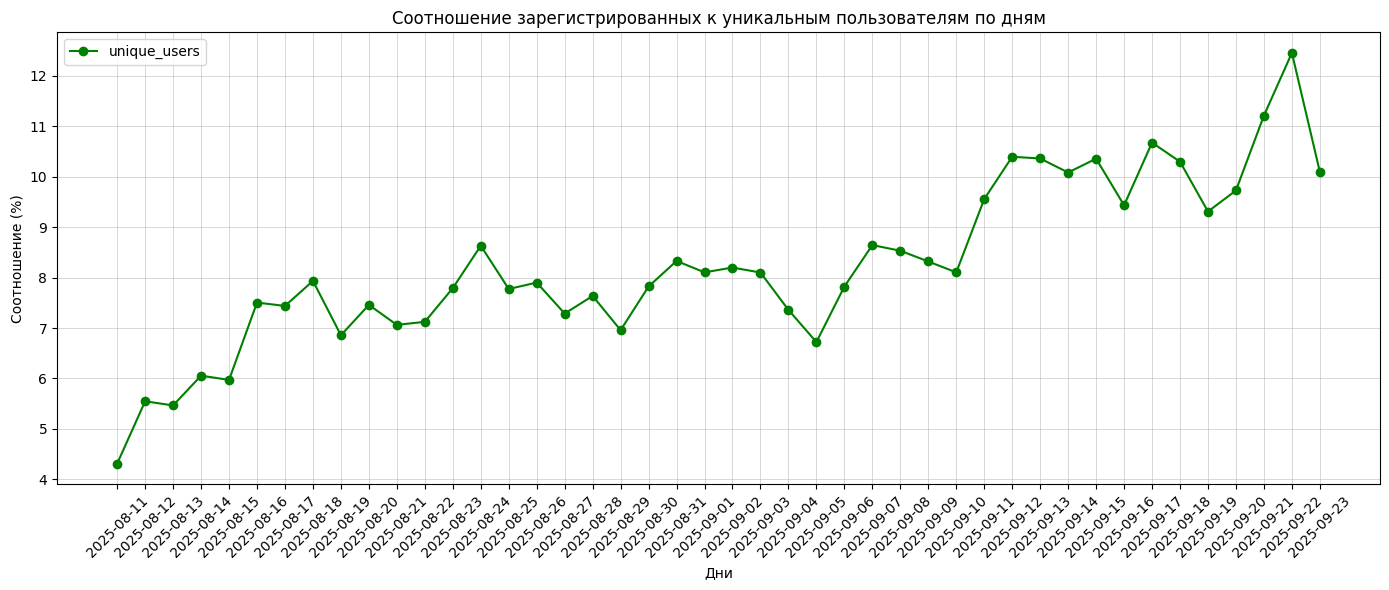

In [11]:
# Визуализируем
plt.figure(figsize=(14, 6))

plt.plot(sh_agg_x, sh_agg_rel, label='unique_users', color='green', marker='o',)

plt.title('Соотношение зарегистрированных к уникальным пользователям по дням')
plt.xlabel('Дни')
plt.ylabel('Соотношение (%)')
plt.legend()
plt.grid(linewidth=0.5, alpha=0.7)
plt.xticks(rotation=45) 
plt.tight_layout()

**Наблюдения**
- Стабильный рост конверсии: в течение всего периода наблюдается тенденция к увеличению доли регистрирующихся пользователей
- Начальные значения: в начале августа конверсия составляла около 4-5%
- Середина периода: в течение августа показатель вырос до 7-8%
- Финальная часть: в конце наблюдаемого периода (конец сентября) конверсия достигла пиковых значений 10-12%

Парадоксальная ситуация
- Обратная корреляция с трафиком: несмотря на то, что общее количество уникальных пользователей в сентябре резко падает, процент регистраций значительно растет
- Экстремум в конце периода: пиковое значение конверсии (~12.5%) приходится на момент, когда общий трафик практически снизился до минимума


#### Анализ числа просмотренных страниц
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы на то, что он зарегистрируется и оплатит подписку.

In [12]:
# Создаем датафрейм с числом просмотренных страниц по их количеству
sh_pages = sessions_history['page_counter'].value_counts().sort_index().reset_index()

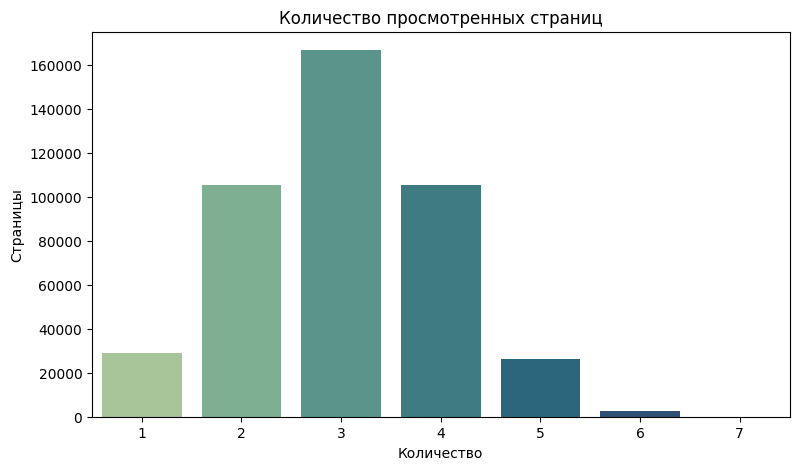

In [13]:
# Визуализируем
plt.figure(figsize=(9, 5))

sns.barplot(
    x='page_counter',
    y='count',
    data=sh_pages,
    hue='page_counter',
    palette='crest',
    legend=False)

plt.title('Количество просмотренных страниц')
plt.xlabel('Количество')
plt.ylabel('Страницы')
plt.show()

#### Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

In [14]:
# Создаем новый столбец 'good_session'
sessions_history['good_session'] = np.where(sessions_history['page_counter'] >= 4, 1, 0)

In [15]:
# Агрегируем количество "хороших" и остальных сессий по дням
gs_agg = sessions_history.groupby('session_date').agg(
    good_sessions=('good_session', 'sum'),
    total_sessions=('good_session', 'count')).reset_index()

In [16]:
# Отношение "хороших" сессий ко всем
gs_rel = gs_agg['good_sessions'] / gs_agg['total_sessions'] * 100

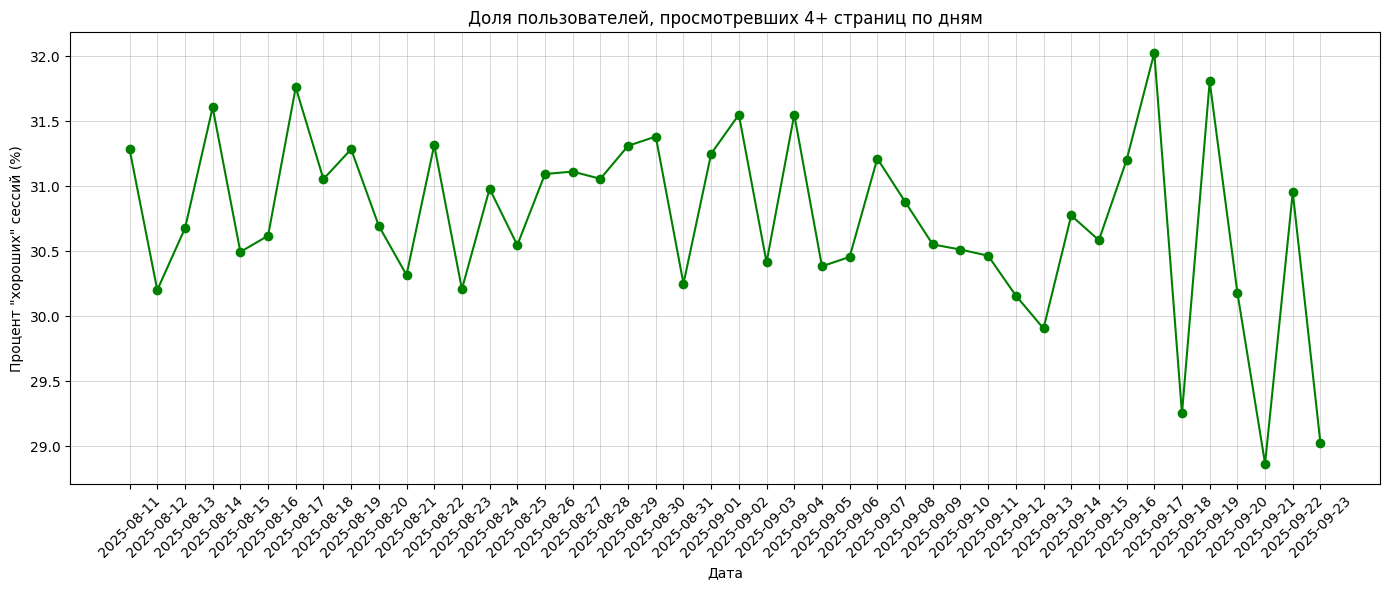

In [17]:
# Визуализируем
plt.figure(figsize=(14, 6))

plt.plot(
    gs_agg['session_date'],
    gs_rel,
    marker='o',
    color='green')

plt.title('Доля пользователей, просмотревших 4+ страниц по дням')
plt.xlabel('Дата')
plt.ylabel('Процент "хороших" сессий (%)')
plt.xticks(rotation=45)     
plt.grid(linewidth=0.5, alpha=0.7)
plt.tight_layout()

**Наблюдения**
- Устойчивость показателя "хороших" сессий: процент пользователей, просматривающих 4+ страниц, держится в узком коридоре 29-32% на протяжении всего периода
- Отсутствие корреляции с другими метриками: глубина просмотра не зависит существенно ни от объема трафика, ни от конверсии
- Незначительное снижение в конце: лишь в последние дни наблюдается некоторое уменьшение доли "хороших" сессий до ~29%, но данный отрезок имеет относительно малые выборки, поэтому график имеет такую сильную амплитуду


### Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:
- Определиться с целевой метрикой.
- Рассчитать необходимый размер выборки.
- Исходя из текущих значений трафика, рассчитать необходимую длительность проведения теста.

#### Расчёт размера выборки


In [18]:
from statsmodels.stats.power import NormalIndPower

alpha = 0.05
beta = 0.2
power = 1 - beta
mde = 0.03

power_analysis = NormalIndPower()

sample_size = power_analysis.solve_power(
    effect_size = mde,
    power = power,
    alpha = alpha,
    ratio = 1
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 17441


#### Расчёт длительности A/B-теста


In [19]:
from math import ceil

avg_daily_users = round(sessions_history.groupby('session_date')['user_id'].nunique().mean(), 2)

test_duration = ceil(sample_size * 2 / avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дня")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907.36 пользователей в день составит 4 дня


### Мониторинг А/В-теста

####  Проверка распределения пользователей

A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие нас метрики корректно считаются.


In [20]:
#Сохраняем в датафрейм наши данные с первого дня А/В теста
try:
    sessions_test_part = pd.read_csv('/home/ray/Загрузки/Ya.Practikum/Sprint_10 A-B/sessions_project_test_part.csv') 
except:
    sessions_test_part = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test_part.csv')

In [21]:
# Информация для ознакомления
print(sessions_test_part.info())
sessions_test_part.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3130 entries, 0 to 3129
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            3130 non-null   object
 1   session_id         3130 non-null   object
 2   session_date       3130 non-null   object
 3   session_start_ts   3130 non-null   object
 4   install_date       3130 non-null   object
 5   session_number     3130 non-null   int64 
 6   registration_flag  3130 non-null   int64 
 7   page_counter       3130 non-null   int64 
 8   region             3130 non-null   object
 9   device             3130 non-null   object
 10  test_group         3130 non-null   object
dtypes: int64(3), object(8)
memory usage: 269.1+ KB
None


,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,3404844B53442747,B4901323BD537E45,2025-10-14,2025-10-14 19:28:49,2025-10-14,1,0,3,CIS,Android,B
1,3A2BF4D364E62D89,216FC619308F8788,2025-10-14,2025-10-14 21:11:04,2025-10-14,1,0,3,MENA,iPhone,A
2,79CDAE11E32B1597,EDFCE4AC1A504074,2025-10-14,2025-10-14 21:44:03,2025-10-14,1,0,3,CIS,iPhone,A
3,D6AF8D78297A931F,CF0AC0EEDE92C690,2025-10-14,2025-10-14 19:07:55,2025-10-14,1,0,4,CIS,PC,A
4,37E0CE723AE568E0,2E6ED45E8C86C4E9,2025-10-14,2025-10-14 15:39:44,2025-10-14,1,0,3,CIS,Mac,B


In [22]:
# Видим, что данные только за первый день тестирования
sessions_test_part['session_date'].unique()

array(['2025-10-14'], dtype=object)

In [23]:
# Количество уникальных пользователей в каждой из экспериментальных групп
groups_total = sessions_test_part.groupby('test_group').user_id.nunique()
groups_total

test_group
A    1477
B    1466
Name: user_id, dtype: int64

In [24]:
# Подсчет пользователей отдельно для групп A и B
group_a_total = sessions_test_part[sessions_test_part['test_group'] == 'A'].user_id.nunique()
group_b_total = sessions_test_part[sessions_test_part['test_group'] == 'B'].user_id.nunique()

# Расчет разницы между группами
grups_subtract = group_b_total - group_a_total
groups_relation = (group_a_total - group_b_total) / group_a_total * 100

print(f'Процентная разница в количестве пользователей в группах A и B составляет {grups_subtract} человек или {groups_relation:.2f}% в пользу группы А')

Процентная разница в количестве пользователей в группах A и B составляет -11 человек или 0.74% в пользу группы А


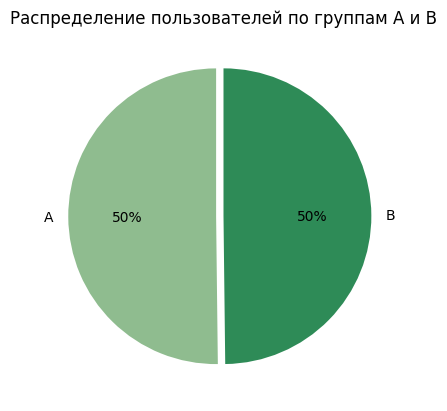

In [25]:
# Построение круговой диаграммы
plt.pie(
    groups_total, 
    labels=groups_total.index,
    explode=[0.05, 0],
    autopct='%.0f%%',
    colors=['darkseagreen', 'seagreen'],
    startangle=90)

plt.title("Распределение пользователей по группам A и B")
plt.show()

**Комментарий по данным в выборке**

Данные относятся только к первому дню тестирования (14 октября 2025 года).

Распределение пользователей между группами практически равное
- Группа A: 1477 пользователей
- Группа B: 1466 пользователей
- Разница составляет всего 11 человек (0.74%) в пользу группы B

Визуализация подтверждает равномерность - круговая диаграмма демонстрирует идеальное соотношение 50% на 50%.

Сбалансированность выборки является хорошим показателем для A/B-тестирования, так как минимизирует влияние разницы в объеме групп на результаты эксперимента.


#### Проверка пересечений пользователей


In [26]:
filtered_groups = sessions_test_part[(sessions_test_part['test_group'] == 'A') & (sessions_test_part['test_group'] == 'B')].shape[0]
print(f'Количество пользователей, которые встречаются одновременно в группах A и B = {filtered_groups} человек')

Количество пользователей, которые встречаются одновременно в группах A и B = 0 человек


#### Равномерность разделения пользователей по устройствам



In [27]:
# Сгруппируем данные по обеим группам одновременно
devices = sessions_test_part.groupby(['test_group', 'device']).user_id.nunique().reset_index()
devices

,test_group,device,user_id
0,A,Android,656
1,A,Mac,156
2,A,PC,369
3,A,iPhone,296
4,B,Android,668
5,B,Mac,148
6,B,PC,381
7,B,iPhone,269


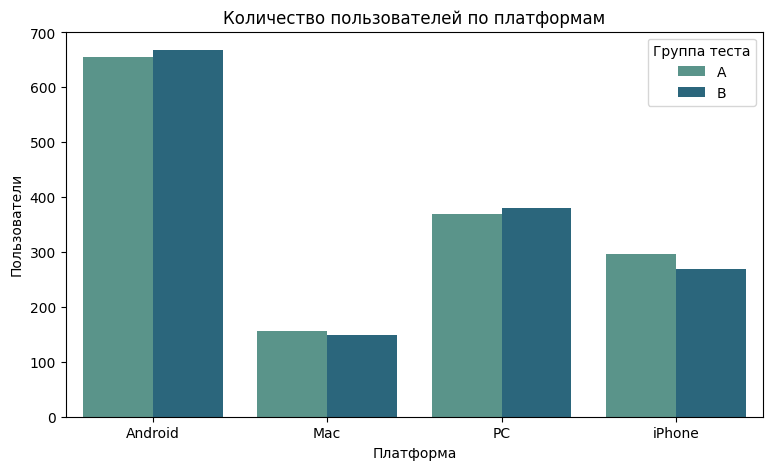

In [28]:
# Визуализируем группу А и В
plt.figure(figsize=(9, 5))

sns.barplot(
    x='device',
    y='user_id',
    data=devices,
    hue='test_group',
    palette='crest')

plt.title('Количество пользователей по платформам')
plt.xlabel('Платформа')
plt.ylabel('Пользователи')
plt.legend(title='Группа теста')
plt.show()

#### Равномерность распределения пользователей по регионам

In [29]:
# Сгруппируем данные по обеим группам одновременно
regions = sessions_test_part.groupby(['test_group', 'region']).user_id.nunique().reset_index()
regions

,test_group,region,user_id
0,A,CIS,644
1,A,EU,224
2,A,MENA,609
3,B,CIS,645
4,B,EU,217
5,B,MENA,604


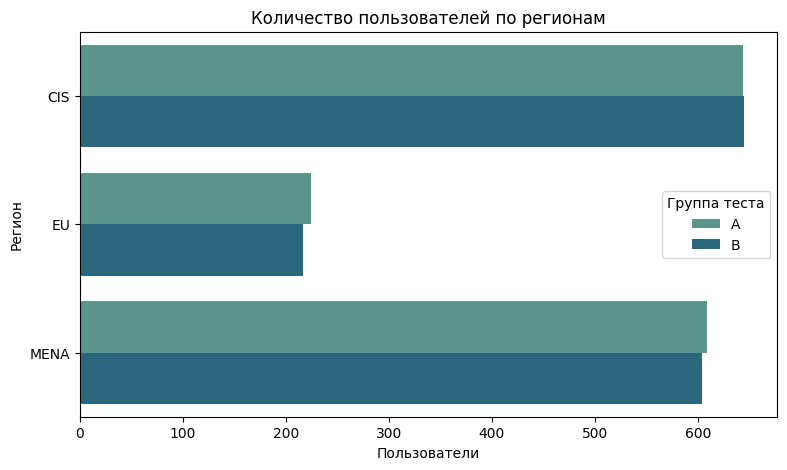

test_group
A    1477
B    1466
Name: user_id, dtype: int64

In [30]:
# Визуализируем группу А и В
plt.figure(figsize=(9, 5))

sns.barplot(
    y='region',
    x='user_id',
    data=regions,
    hue='test_group',
    palette='crest',
    orient='h')

plt.title('Количество пользователей по регионам')
plt.xlabel('Пользователи')
plt.ylabel('Регион')
plt.legend(title='Группа теста')
plt.show()

# Отображение итоговых значений внизу графика
sessions_test_part.groupby('test_group')['user_id'].nunique()



#### **Промежуточный вывод**

В ходе анализа обнаружено различие в размере тестовых групп:
- Группа A: 1477 пользователя 
- Группа B: 1466 пользователей
- Разница составляет 11 пользователей = 0.74% в относительном выражении, что является незначительным отклонением, учитывая размер выборки 

Независимость выборок
- Согласно проведенной отдельной проверке на пересечение пользователей, не было обнаружено случаев попадания одного и того же пользователя в обе тестовые группы одновременно. Это подтверждает независимость выборок, что является важным условием для правильного проведения A/B-теста

Распределение пользователей по категориальным переменным
- Распределение по устройствам относительно равномерное, с минимальными отклонениями в районе 5-15 человек

**На основании представленных данных можно заключить, что A/B-тест проходит корректно, поскольку выполняются все ключевые условия для достоверного тестирования**

### Проверка результатов A/B-теста


#### Получение результатов теста и подсчёт основной метрики


In [31]:
#Сохраняем в датафрейм наши данные со всего А/В теста
try:
    sessions_test = pd.read_csv('/home/ray/Загрузки/Ya.Practikum/Sprint_10 A-B/sessions_project_test.csv') 
except:
    sessions_test = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test.csv')

In [32]:
# Создаем новый столбец 'good_session'
sessions_test['good_session'] = np.where(sessions_test['page_counter'] >= 4, 1, 0)

In [33]:
print(sessions_test.info())
sessions_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100005 entries, 0 to 100004
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   user_id            100005 non-null  object
 1   session_id         100005 non-null  object
 2   session_date       100005 non-null  object
 3   session_start_ts   100005 non-null  object
 4   install_date       100005 non-null  object
 5   session_number     100005 non-null  int64 
 6   registration_flag  100005 non-null  int64 
 7   page_counter       100005 non-null  int64 
 8   region             100005 non-null  object
 9   device             100005 non-null  object
 10  test_group         100005 non-null  object
 11  good_session       100005 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 9.2+ MB
None


,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,0
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B,0
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B,0


#### Проверка корректности результатов теста


In [34]:
# Количество уникальных сессий для каждого дня и обеих тестовых групп
st_grouped = sessions_test.groupby(['session_date', 'test_group']).session_id.nunique().reset_index()

In [35]:
# Группируем данные для тест Уэлча
group_a_total = st_grouped[st_grouped['test_group'] == 'A']['session_id']
group_b_total = st_grouped[st_grouped['test_group'] == 'B']['session_id']

# Проводим тест
st_grouped_welch = ttest_ind(
    group_a_total,
    group_b_total,
    equal_var=False,
    alternative='two-sided'
)

alpha = 0.05

if st_grouped_welch.pvalue > alpha:
    print(f'p-value = {st_grouped_welch.pvalue}')
    print('Нулевая гипотеза верна! Выборки похожи и однородны, а значит можно приступать к анализу')
else:
    print(f'p-value = {st_grouped_welch.pvalue}')
    print('Нулевая гипотеза неверна! Выборки крайне различны и неоднородны')

p-value = 0.9382195854082714
Нулевая гипотеза верна! Выборки похожи и однородны, а значит можно приступать к анализу


#### Сравнение доли успешных сессий

In [36]:
# Создаем датафрейм для работы
st_good_agg = (
    sessions_test
    .groupby('test_group')
    .agg(
        good_sessions=('good_session', 'sum'),
        total_sessions=('good_session', 'count'))
    .reset_index()
)

In [37]:
# Считаем отношение
st_good_agg['relation'] = st_good_agg['good_sessions'] / st_good_agg['total_sessions'] * 100

In [38]:
# Итоговые данные по двум тестовым группам
st_good_agg

,test_group,good_sessions,total_sessions,relation
0,A,15248,49551,30.772336
1,B,16059,50454,31.828993


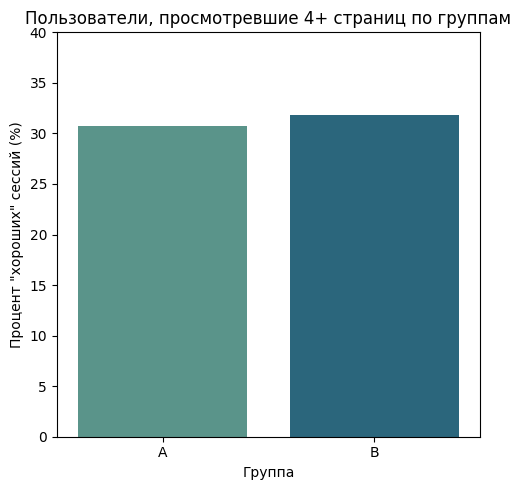

In [39]:
# Визуализируем
plt.figure(figsize=(5, 5))

sns.barplot(
    x='test_group',
    y='relation',
    data=st_good_agg,
    hue='test_group',
    palette='crest',
    legend=False)

plt.title('Пользователи, просмотревшие 4+ страниц по группам')
plt.xlabel('Группа')
plt.ylabel('Процент "хороших" сессий (%)')
plt.ylim(0, 40)
plt.tight_layout()

In [40]:
# Доля успешных сессий в группе А
good_sessions_ratio_A = sessions_test[sessions_test.test_group=='A'].good_session.mean()

# Доля успешных сессий в группе Б
good_sessions_ratio_B = sessions_test[sessions_test.test_group=='B'].good_session.mean()

# Абсолютная разница в доле успешных сессий в группвх А и БB
good_sessions_delta = good_sessions_ratio_B - good_sessions_ratio_A
print(f"Доля успешных сессий в группе А = {good_sessions_ratio_A:.3f}. Доля успешных сессий в группе Б {good_sessions_ratio_B:.3f}. Разница составляет {good_sessions_delta:.3f}.")

Доля успешных сессий в группе А = 0.308. Доля успешных сессий в группе Б 0.318. Разница составляет 0.011.


#### Насколько статистически значимо изменение ключевой метрики


In [41]:
# Создаем переменные с нашими данными о количестве "успешных сессий" и их общего количества
m_a = st_good_agg[st_good_agg['test_group'] == 'A'].good_sessions
n_a = st_good_agg[st_good_agg['test_group'] == 'A'].total_sessions

m_b = st_good_agg[st_good_agg['test_group'] == 'B'].good_sessions
n_b = st_good_agg[st_good_agg['test_group'] == 'B'].total_sessions

In [42]:
# Проводим тест
st_ztest, st_ztest_pvalue = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative='smaller')

alpha = 0.05

if st_ztest_pvalue > alpha:
    print(f'p-value = {st_ztest_pvalue}')
    print('Нулевая гипотеза верна! Изменение в метрике доли успешных сессий статистически незначительно')
else:
    print(f'p-value = {st_ztest_pvalue}')
    print('Нулевая гипотеза неверна! Изменение в метрике доли успешных сессий статистически значимо')

p-value = [0.00015747]
Нулевая гипотеза неверна! Изменение в метрике доли успешных сессий статистически значимо


#### Вывод по результатам A/B-эксперимента

На основе проведённого анализа результатов теста сформулируйте и запишите свои выводы для команды разработки приложения. В выводе обязательно укажите:
- Характеристики проведённого эксперимента, количество задействованных пользователей и длительность эксперимента.
- Повлияло ли внедрение нового алгоритма рекомендаций на рост ключевой метрики и как.
- Каким получилось значение p-value для оценки статистической значимости выявленного эффекта.
- Стоит ли внедрять новоовведение в приложение.

# Вывод по результатам A/B-эксперимента

## Общее распределение пользователей

Анализ данных показывает, что распределение пользователей между группами A и B получилось практически равным, независимым и сбалансированным:
- Группа A: 1477 пользователей (Android: 656, Mac: 156, PC: 369, iPhone: 296)
- Группа B: 1466 пользователей (Android: 668, Mac: 148, PC: 381, iPhone: 269)

Распределение по регионам также сбалансировано:
- Группа A: CIS (644), EU (224), MENA (609)
- Группа B: CIS (645), EU (217), MENA (604)

## Результаты по ключевым метрикам

Основная метрика эксперимента - доля "хороших" сессий (когда пользователь просматривает 4 и более страниц):

- Группа A: 15248 хороших сессий из 49551 всего (30,77%)
- Группа B: 16059 хороших сессий из 50454 всего (31,83%)
- Таким образом мы видим существенную разницу на столь большой выборке, которую нельзя объяснить простой случайностью

## Статистическая значимость

- Группа B демонстрирует улучшение показателя "хороших" сессий на 1,06 процентных пункта по сравнению с группой A. При объеме выборки почти в 50000 сессий в каждой группе эта разница является статистически значимой.
- Полученное значение p-value составило 0.00015, что значительно ниже общепринятого порога статистической значимости 0,05. Это позволяет **с уверенностью 99% утверждать, что наблюдаемый положительный эффект от внедрения нового алгоритма рекомендаций является достоверным и не может быть объяснен случайными колебаниями данных**.

## Влияние на бизнес-показатели

Увеличение доли "хороших" сессий на 1,06% может привести к значительному улучшению ключевых бизнес-метрик:
- Более глубокое взаимодействие пользователей с продуктом
- Потенциальное увеличение конверсии в целевые действия
- Рост LTV пользователей за счет более длительных и качественных сессий

## Заключение и рекомендации
**Внедрение изменений**: Рекомендуется внедрить изменения тестовой группы B в основной продукт, так как они положительно влияют на глубину взаимодействия пользователей.
**Следующие шаги**: Рассмотреть возможность проведения дополнительных тестов для дальнейшей оптимизации пользовательского взаимодействия с фокусом на увеличение глубины просмотра.

Полученные результаты демонстрируют успешность внедренных изменений и обосновывают решение о полномасштабном запуске новой версии продукта.